In [1]:
from findthegap.gapper import Gapper

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

from sklearn.preprocessing import StandardScaler

import torch

### Data

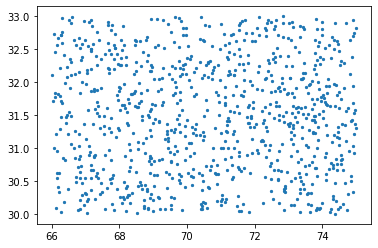

In [3]:
## Make fake data

xlims = (66, 75)
ylims =  (30,33)

background = np.random.uniform([xlims[0], ylims[0]], [xlims[1],ylims[1]], [900,2])
plt.scatter(background[:,0], background[:,1], s=5)

(600, 2)


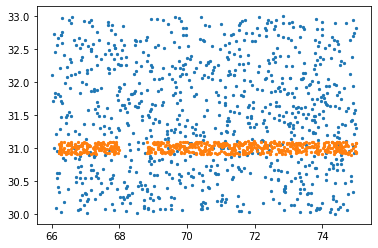

In [4]:

stream = np.random.uniform( [66.2, 30.9], [68., 31.1], [150,2])
stream2 = np.random.uniform( [68.8, 30.9], [75, 31.1], [450,2])

## So the gap is of size ".8"

stream = np.vstack([stream,stream2])
print(stream.shape)
data = np.vstack([stream,background])
plt.scatter(background[:,0], background[:,1], s=5)
plt.scatter(stream[:,0], stream[:,1], s=5)

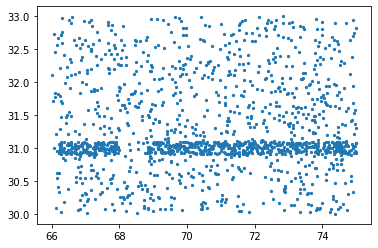

In [5]:
plt.scatter(data[:,0], data[:,1], s=5)

### Normalize data


In [6]:
## We don't normalize the data ?

In [7]:
# Boundaries for the Gapper (if none are provided, this is the default mode)
bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])


## Create a Gapper

In [8]:

bw = .5 ## This happens to be the width of the gap
gapper_base = Gapper(data, bw, bounds)

### Compute the density estimate on a grid over the dataspace

#### Bypassing the wrapper because of the squared gridding function hidden in it

Need to redefin a grid_data that matches the fact that you are not 'squared'

your gridding_size is different in x and y. I think you want a fixed grid for all your runs across different bandwidths, so you should pick a gridding size that matches the smallest bandwidth you plan to use. I think you want to ensure that your griddind is such that one 'cell' is the span of a bandwidth....But take this with a pinch of salt?

In [9]:
min_bw = .04

print(xlims, ylims)
gridding_size = [ int((xlims[1]-xlims[0])/min_bw), int((ylims[1]-ylims[0])/min_bw)]
print(gridding_size)
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
print(grid_linspace[0].shape, grid_linspace[1].shape)

meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
grid_data = np.hstack(meshgrid_ravel)
print(grid_data.shape)

(66, 75) (30, 33)
[225, 75]
(225,) (75,)
(16875, 2)


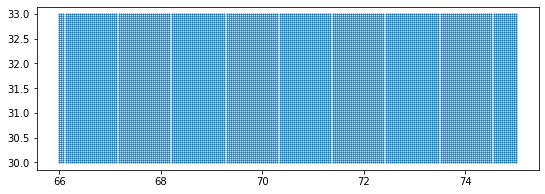

In [10]:
## grid_data should contain poitns spaced by "bw" spanning the entire data_space. looks weird prob because of 
## visualization artifact?
plt.figure(figsize=(xlims[1]-xlims[0],ylims[1]-ylims[0]))
plt.scatter(grid_data[:,0], grid_data[:,1], s=1)

In [11]:
##

t = time.time()
grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))
print((time.time() - t))

2.613502025604248


In [12]:

density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))

In [13]:
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(data.shape[1]) ]
meshgrid = np.array(np.meshgrid(*grid_linspace, indexing='ij'))

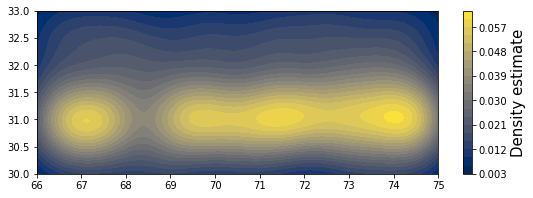

In [14]:

fontsize=15
xsize,ysize = xlims[1]-xlims[0],ylims[1]-ylims[0]
plt.figure(figsize=(xsize,ysize))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)
cb = plt.colorbar(label='Density estimate')

plt.xlim(*xlims)
plt.ylim(*ylims)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)


plt.show()

## Making a map of maximum eigenvalue of Hessian

In [15]:
t = time.time()
hessian_grid = np.array([gapper_base.get_Hessian(pt) for pt in grid_data])
eig_vals_H = np.array([np.linalg.eigh(hessian_grid[i])[0] for i in range(hessian_grid.shape[0])])

print(time.time() -t)

17.74693202972412


In [16]:
hessian_grid.shape

(16875, 2, 2)

In [17]:
eig_vals_H.shape

(16875, 2)

In [18]:
max_eig_vals_H_grid = np.max(eig_vals_H, axis=1).reshape((gridding_size[0], gridding_size[1]))

No handles with labels found to put in legend.


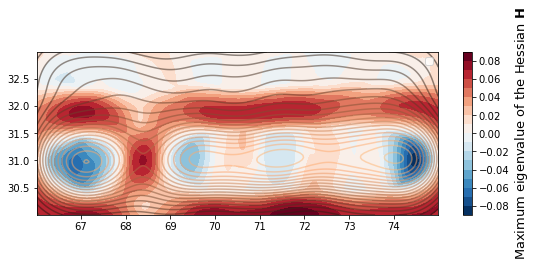

In [19]:
plt.figure(figsize=(xsize,ysize))

plt.contourf(meshgrid[0], meshgrid[1], max_eig_vals_H_grid, 20, cmap=cm.RdBu.reversed(),
             vmin = -(np.max(np.abs(max_eig_vals_H_grid))), vmax=np.max(np.abs(max_eig_vals_H_grid)))

cb = plt.colorbar(label="Maximum eigenvalue of the Hessian $\mathbf{H}$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.copper, alpha=.5)


# critsc = plt.scatter(critical_points[idx_best_crits][:,0], critical_points[idx_best_crits][:,1], 
#                      s=80, c="None", edgecolor='k', label='{} best critical points'.format(N))

plt.legend()


plt.show()



## Computing PiHPi (projection of the Hessian into the orthogonal subspace of the density gradient) matrix

In [20]:
t = time.time()

## If the gradient and Hessian have been computed before, they can be put as argument of that function to avoid
## recomputing them

PiHPis_grid = []
eigval_PiHPi = [] 

for pt in grid_data:
    _pihpi = gapper_base.get_PiHPi(pt) 
    _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)
    
    PiHPis_grid.append(_pihpi)
    eigval_PiHPi.append(_pihpi_eigval)

print(time.time() -t)

24.913565158843994


## Maximum eigenvalue of PiHPi as gap-criterion

In [21]:


PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)

In [22]:
eigval_PiHPi.shape

(16875, 2)

In [23]:

max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
max_eigval_PiHPi.shape

(16875,)

In [24]:

max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size[0], gridding_size[1]))

No handles with labels found to put in legend.


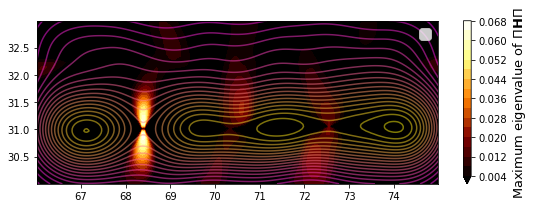

In [25]:


plt.figure(figsize=(xsize, ysize))

pi = plt.contourf(meshgrid[0], meshgrid[1], max_eigval_PiHPi_resh, 20, cmap=cm.afmhot, extend='min')
plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)


cb = plt.colorbar(pi, label="Maximum eigenvalue of $\Pi \mathbf{H} \Pi$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.show()

No handles with labels found to put in legend.


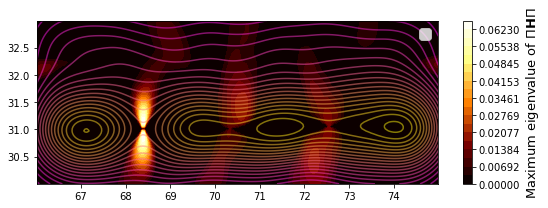

In [26]:


plt.figure(figsize=(xsize, ysize))

pi = plt.contourf(meshgrid[0], meshgrid[1], max_eigval_PiHPi_resh,
                  np.linspace(max_eigval_PiHPi_resh.min(), max_eigval_PiHPi_resh.max(), 20), cmap=cm.afmhot)
plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)


cb = plt.colorbar(pi, label="Maximum eigenvalue of $\Pi \mathbf{H} \Pi$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.show()

### Making a cut to get the regions with the highest maximum-eigenvalue-of-PiHPi criterion

In [27]:
threshold = np.percentile(max_eigval_PiHPi, 99) 
mask = max_eigval_PiHPi > threshold

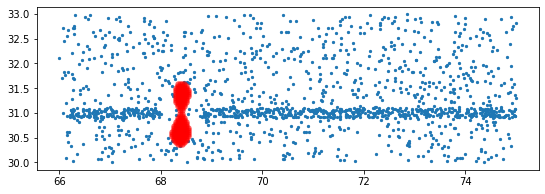

In [28]:

plt.figure(figsize=(xsize, ysize))
plt.scatter(data[:,0], data[:,1], s=5)
plt.scatter(grid_data[mask,0], grid_data[mask,1], s=30, c='r' ,alpha=.5)

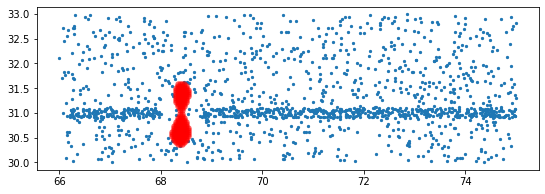

In [29]:
threshold = np.percentile(max_eigval_PiHPi, 99.) 
mask = max_eigval_PiHPi > threshold
plt.figure(figsize=(xsize, ysize))
plt.scatter(data[:,0], data[:,1], s=5)
plt.scatter(grid_data[mask,0], grid_data[mask,1], s=30, c='r' ,alpha=.5)

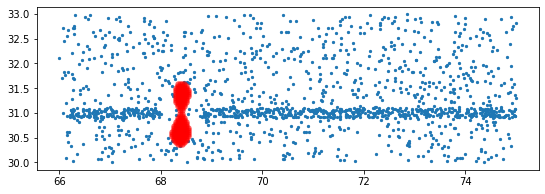

In [30]:
threshold = np.percentile(max_eigval_PiHPi, 99.) 
mask = max_eigval_PiHPi > threshold
plt.figure(figsize=(xsize, ysize))
plt.scatter(data[:,0], data[:,1], s=5)
plt.scatter(grid_data[mask,0], grid_data[mask,1], s=30, c='r' ,alpha=.5)

### My intuition is: 
If you re-run with the same bandwidth (doing bootstrapping or resampling), and average or take the median of that max_eigval_PiHPi array and then do the selection, hopefully the spurious one should disappear

Smaller bandwdith might not detect the gap. You might want actually a bigger bandiwdith than the gap. But that can say interesting things about the gaps you find? I don't know

One other potential issue for which right now I have no good answer is : what happens if there is *no gap* and how your pipeline should handle it

## Bootstrapping.

Tried with a lower bandwidth to see if it could get the gap / remove spurious thing. But it's meh?

In [31]:
maxeigval_PiHPi_boots = []

bw = .3

for i in range(5):
    
    boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                 replace=True) ## Sample with replacement:bootstrap
    
    gapper_ = Gapper(data[boot_indx], bw, bounds)
    PiHPis_grid = []
    eigval_PiHPi = [] 

    for pt in grid_data:
        _pihpi = gapper_.get_PiHPi(pt) 
        _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

        PiHPis_grid.append(_pihpi)
        eigval_PiHPi.append(_pihpi_eigval)
        
    PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
    max_eigval_PiHPi_k = np.max(eigval_PiHPi, axis=1)
    maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
    print(f'Run {i} finished')

Run 0 finished
Run 1 finished
Run 2 finished
Run 3 finished
Run 4 finished


In [32]:
maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
print(maxeigval_PiHPi_boots.shape)

(5, 16875)


In [33]:
med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0)

In [34]:
med_maxeigval_pihpi_resh = med_maxeigval_pihpi.reshape((gridding_size[0], gridding_size[1]))

No handles with labels found to put in legend.


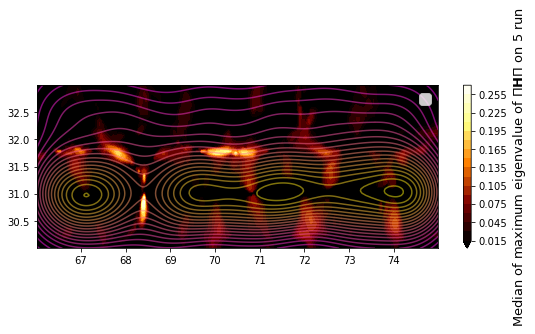

In [35]:


plt.figure(figsize=(xsize, ysize))

pi = plt.contourf(meshgrid[0], meshgrid[1], med_maxeigval_pihpi_resh, 20, cmap=cm.afmhot, extend='min')
plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)


cb = plt.colorbar(pi, label="Median of maximum eigenvalue of $\Pi \mathbf{H} \Pi$ on 5 run")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.show()

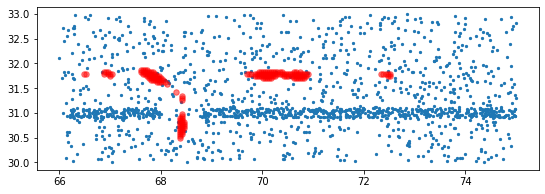

In [36]:
threshold = np.percentile(med_maxeigval_pihpi, 99) 
mask = med_maxeigval_pihpi > threshold
plt.figure(figsize=(xsize, ysize))
plt.scatter(data[:,0], data[:,1], s=5)
plt.scatter(grid_data[mask,0], grid_data[mask,1], s=30, c='r' ,alpha=.5)

## Try averaging across bw / bootstrap

In [37]:
min_bw = .03

print(xlims, ylims)
gridding_size = [ int((xlims[1]-xlims[0])/min_bw), int((ylims[1]-ylims[0])/min_bw)]
print(gridding_size)
grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
print(grid_linspace[0].shape, grid_linspace[1].shape)

meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
grid_data = np.hstack(meshgrid_ravel)
print(grid_data.shape)

(66, 75) (30, 33)
[300, 100]
(300,) (100,)
(30000, 2)


In [38]:
list_of_bws = [.1, .3, .5, .75, 1.]
nb_of_boot = 3


In [39]:
dic_grid_density = {}
dic_density_matr = {}
dic_eigval_PihPi = {}
dic_maxeigval_PiHPi_resh = {}

for i in range(nb_of_boot):
    for bw in list_of_bws:
        
        key = str(i)+"_"+ str(bw)
        print(key)
        boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                 replace=True) ## Sample with replacement:bootstrap
    
        gapper_ = Gapper(data[boot_indx], bw, bounds)

        t = time.time()
        grid_density = gapper_.kde.score_samples(torch.tensor(grid_data))
        density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = gapper_.get_PiHPi(pt) 
            _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
        max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size[0], gridding_size[1]))
        
        
        dic_grid_density[key] = grid_density
        dic_density_matr[key] = density_matr
        dic_eigval_PihPi[key] = eigval_PiHPi
        dic_maxeigval_PiHPi_resh[key] = max_eigval_PiHPi_resh
        
        print("For bw: {}, bootstrap={}".format(bw, i))
        print((time.time() - t))

0_0.1
For bw: 0.1, bootstrap=0
43.12233090400696
0_0.3
For bw: 0.3, bootstrap=0
45.0523898601532
0_0.5
For bw: 0.5, bootstrap=0
47.802149295806885
0_0.75
For bw: 0.75, bootstrap=0
51.81011199951172
0_1.0
For bw: 1.0, bootstrap=0
55.557836055755615
1_0.1
For bw: 0.1, bootstrap=1
42.959338903427124
1_0.3
For bw: 0.3, bootstrap=1
45.56590723991394
1_0.5
For bw: 0.5, bootstrap=1
47.87165379524231
1_0.75
For bw: 0.75, bootstrap=1
51.92956018447876
1_1.0
For bw: 1.0, bootstrap=1
55.28838300704956
2_0.1
For bw: 0.1, bootstrap=2
42.97069478034973
2_0.3
For bw: 0.3, bootstrap=2
45.05328893661499
2_0.5
For bw: 0.5, bootstrap=2
208.1676208972931
2_0.75
For bw: 0.75, bootstrap=2
51.738107204437256
2_1.0
For bw: 1.0, bootstrap=2
58.003491163253784


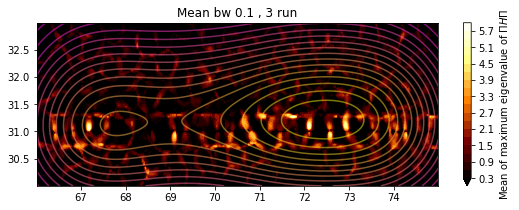

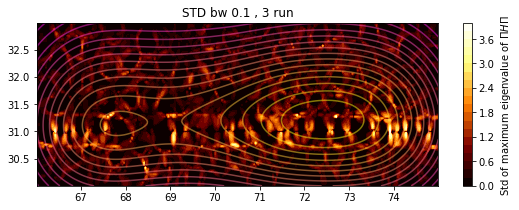

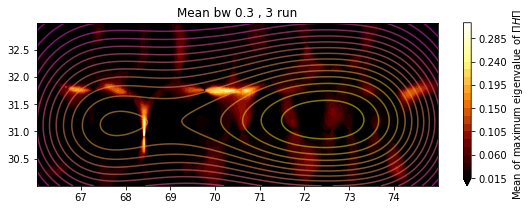

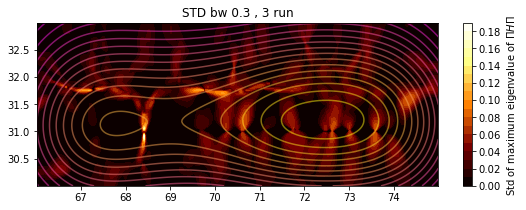

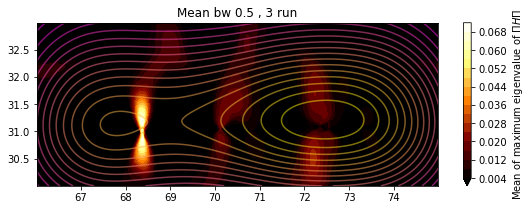

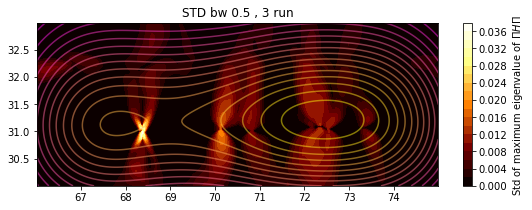

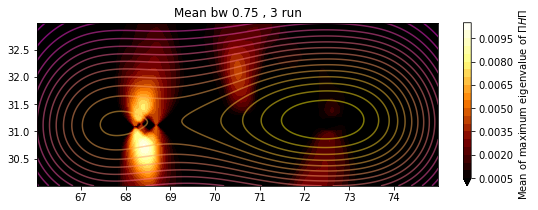

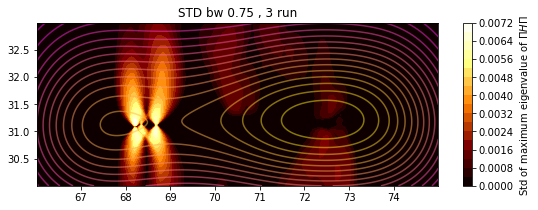

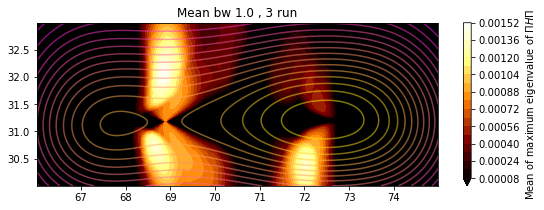

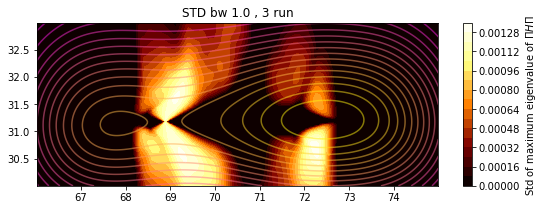

In [40]:
## Average over boot and... over bw?

## Average over boot first and check mean / std for each bw:

for bw in list_of_bws:
    
    all_maxeigval = np.zeros((nb_of_boot, gridding_size[0], gridding_size[1]))
    for i in range(nb_of_boot):
        key = str(i)+"_"+ str(bw)
        all_maxeigval[i] = dic_maxeigval_PiHPi_resh[key]
    avg_maxeigval = np.mean(all_maxeigval, axis=0)
    std_maxeigval = np.std(all_maxeigval, axis=0)
    

    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], avg_maxeigval, 20, cmap=cm.afmhot, extend='min')
    plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Mean of maximum eigenvalue of $\Pi H \Pi$")
    plt.title(f"Mean bw {bw} , {nb_of_boot} run")
    plt.show()
    
    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], std_maxeigval, 20, cmap=cm.afmhot)#, extend='min')
    plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Std of maximum eigenvalue of $\Pi H \Pi$ ")
    plt.title(f"STD bw {bw} , {nb_of_boot} run")
    plt.show()
    
    
    print("=="*5)

In [41]:
from sklearn.preprocessing import MinMaxScaler

## Rescale each "max-eigval PiHPi" grid so that values are within 0-1

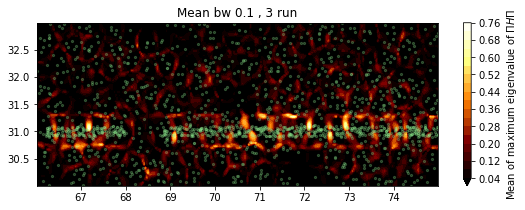

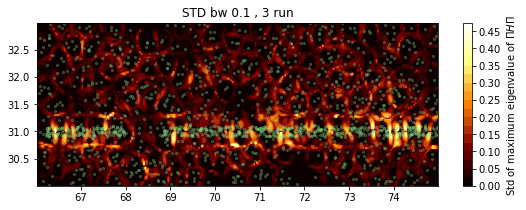

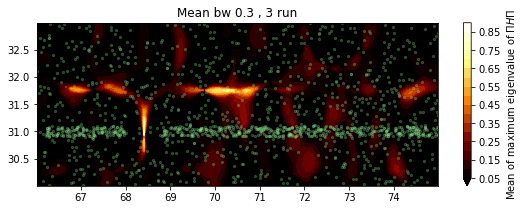

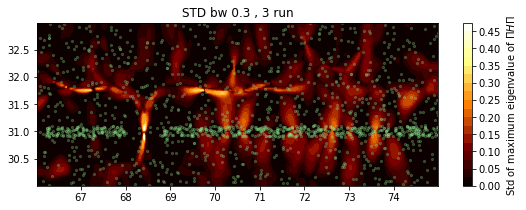

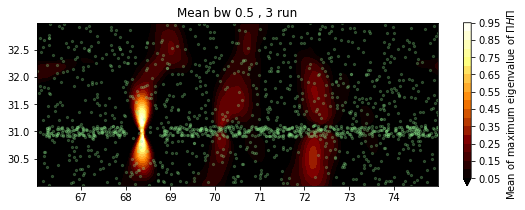

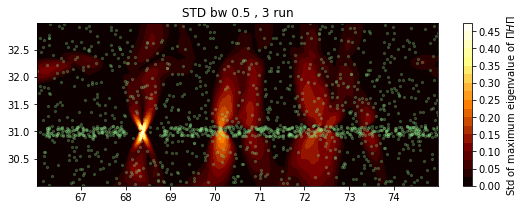

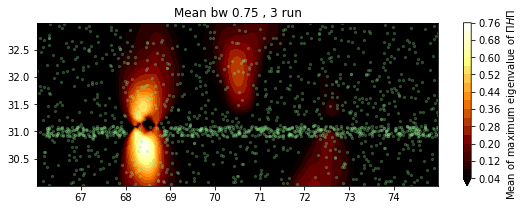

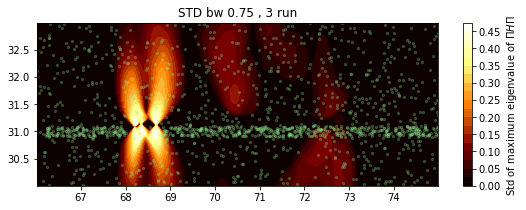

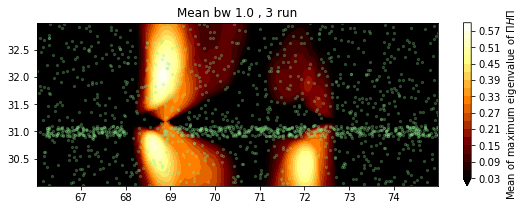

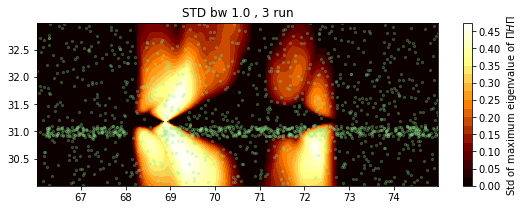

In [42]:
## Average over boot and... over bw?

## Average over boot first and check mean / std for each bw:

for bw in list_of_bws:
    
    all_maxeigval = np.zeros((nb_of_boot, gridding_size[0], gridding_size[1]))
    for i in range(nb_of_boot):
        key = str(i)+"_"+ str(bw)
        all_maxeigval[i] = MinMaxScaler().fit_transform(dic_maxeigval_PiHPi_resh[key].reshape(-1,1)).reshape((gridding_size[0],
                                                                                                            gridding_size[1]))
    avg_maxeigval = np.mean(all_maxeigval, axis=0)
    std_maxeigval = np.std(all_maxeigval, axis=0)
    

    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], avg_maxeigval, 20, cmap=cm.afmhot, extend='min')
    plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)
    #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Mean of maximum eigenvalue of $\Pi H \Pi$")
    plt.title(f"Mean bw {bw} , {nb_of_boot} run")
    plt.show()
    
    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], std_maxeigval, 20, cmap=cm.afmhot)#, extend='min')
    plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)
    #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Std of maximum eigenvalue of $\Pi H \Pi$ ")
    plt.title(f"STD bw {bw} , {nb_of_boot} run")
    plt.show()
    
    
    print("=="*5)

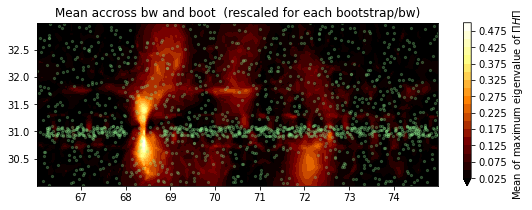

In [43]:
## Average over boot and... over bw?

## Average over boot first and check mean / std for each bw:
cnt_ = 0

all_maxeigval = np.zeros((nb_of_boot*len(list_of_bws), gridding_size[0], gridding_size[1]))
for bw in list_of_bws:
    
    for i in range(nb_of_boot):
        key = str(i)+"_"+ str(bw)
        all_maxeigval[cnt_] = MinMaxScaler().fit_transform(
                                dic_maxeigval_PiHPi_resh[key].reshape(-1,1)).reshape((gridding_size[0],
                                                                                    gridding_size[1]))
        cnt_+=1
        
avg_maxeigval = np.mean(all_maxeigval, axis=0)
std_maxeigval = np.std(all_maxeigval, axis=0)

 


plt.figure(figsize=(xsize, ysize))
pi = plt.contourf(meshgrid[0], meshgrid[1], avg_maxeigval, 20, cmap=cm.afmhot, extend='min')
plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)

#plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
#plt.scatter(data[:,0], data[:,1], s=5)
cb = plt.colorbar(pi, label=f"Mean of maximum eigenvalue of $\Pi H \Pi$")
plt.title(f"Mean accross bw and boot  (rescaled for each bootstrap/bw)")
plt.show()



# plt.figure(figsize=(xsize, ysize))
# pi = plt.contourf(meshgrid[0], meshgrid[1], std_maxeigval, 20, cmap=cm.afmhot)#, extend='min')
# #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
# plt.scatter(data[:,0], data[:,1], s=5)
# cb = plt.colorbar(pi, label=f"Std of maximum eigenvalue of $\Pi H \Pi$ ")
# plt.title(f"Std  bw {bw} , {nb_of_boot} run")
# plt.show()

## Try with  Normalized data 

In [44]:
xlims[1]-xlims[0]

9

In [45]:
## Gap is of size .8 in original space in x, soooo, equivalent-ish .09 in rescaled space?
minmaxscal = MinMaxScaler().fit(data)
data_resc = minmaxscal.transform(data)
grid_data_resc = minmaxscal.transform(grid_data)
bw = .05 ## This happens to be the width of the gap
gapper_base = Gapper(data_resc, bw, bounds)

In [46]:
##

t = time.time()
grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data_resc))
print((time.time() - t))
density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))


3.547724962234497


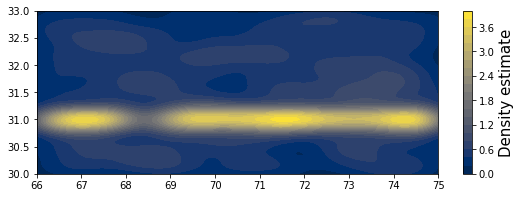

In [47]:
fontsize=15
xsize,ysize = xlims[1]-xlims[0],ylims[1]-ylims[0]
plt.figure(figsize=(xsize,ysize))

ctf = plt.contourf(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.cividis)
cb = plt.colorbar(label='Density estimate')

plt.xlim(*xlims)
plt.ylim(*ylims)

ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize)
text.set_font_properties(font)


plt.show()

In [48]:

t = time.time()

## If the gradient and Hessian have been computed before, they can be put as argument of that function to avoid
## recomputing them

PiHPis_grid = []
eigval_PiHPi = [] 

for pt in grid_data_resc:
    _pihpi = gapper_base.get_PiHPi(pt) 
    _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)
    
    PiHPis_grid.append(_pihpi)
    eigval_PiHPi.append(_pihpi_eigval)

print(time.time() -t)
PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
max_eigval_PiHPi.shape


41.80793023109436


(30000,)

No handles with labels found to put in legend.


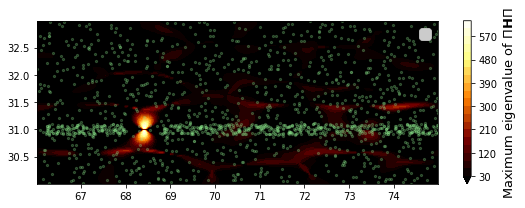

In [49]:
max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size[0], gridding_size[1]))
plt.figure(figsize=(xsize, ysize))

pi = plt.contourf(meshgrid[0], meshgrid[1], max_eigval_PiHPi_resh, 20, cmap=cm.afmhot, extend='min')
#plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)

plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)
    
cb = plt.colorbar(pi, label="Maximum eigenvalue of $\Pi \mathbf{H} \Pi$")
ax = cb.ax
text = ax.yaxis.label
font = matplotlib.font_manager.FontProperties(size=fontsize-2)
text.set_font_properties(font)

plt.legend(fontsize=15)

plt.show()

In [50]:
list_of_bws

[0.1, 0.3, 0.5, 0.75, 1.0]

In [51]:
list_of_bws_resc = [.01, .04, .07, .1, .15] ## Need to use different bandwidths now. 
rescaler = MinMaxScaler().fit(grid_data)

dic_grid_density_rescl = {}
dic_density_matr_rescl = {}
dic_eigval_PihPi_rescl = {}
dic_maxeigval_PiHPi_resh_rescl = {}

minmaxscal = MinMaxScaler().fit(data)
#data_resc = minmaxscal.transform(data)
grid_data_resc = minmaxscal.transform(grid_data)

for i in range(nb_of_boot):
    for bw in list_of_bws_resc:
        
        key = str(i)+"_"+ str(bw)
        print(key)
        boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                 replace=True) ## Sample with replacement:bootstrap
        
        data_resc = minmaxscal.transform(data[boot_indx]) 
        gapper_ = Gapper(data_resc, bw, bounds)

        t = time.time()
        grid_density = gapper_.kde.score_samples(torch.tensor(grid_data_resc))
        density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data_resc:
            _pihpi = gapper_.get_PiHPi(pt) 
            _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        max_eigval_PiHPi = np.max(eigval_PiHPi, axis=1)
        max_eigval_PiHPi_resh = max_eigval_PiHPi.reshape((gridding_size[0], gridding_size[1]))
        
        
        dic_grid_density_rescl[key] = grid_density
        dic_density_matr_rescl[key] = density_matr
        dic_eigval_PihPi_rescl[key] = eigval_PiHPi
        dic_maxeigval_PiHPi_resh_rescl[key] = max_eigval_PiHPi_resh
        
        print("For bw: {}, bootstrap={}".format(bw, i))
        print((time.time() - t))

0_0.01
For bw: 0.01, bootstrap=0
42.22944092750549
0_0.04
For bw: 0.04, bootstrap=0
44.9036591053009
0_0.07
For bw: 0.07, bootstrap=0
46.373680114746094
0_0.1
For bw: 0.1, bootstrap=0
49.32368183135986
0_0.15
For bw: 0.15, bootstrap=0
55.147895097732544
1_0.01
For bw: 0.01, bootstrap=1
43.79387092590332
1_0.04
For bw: 0.04, bootstrap=1
45.42274808883667
1_0.07
For bw: 0.07, bootstrap=1
46.35779905319214
1_0.1
For bw: 0.1, bootstrap=1
49.648090839385986
1_0.15
For bw: 0.15, bootstrap=1
56.94063711166382
2_0.01
For bw: 0.01, bootstrap=2
43.15216279029846
2_0.04
For bw: 0.04, bootstrap=2
45.184699058532715
2_0.07
For bw: 0.07, bootstrap=2
47.50183129310608
2_0.1
For bw: 0.1, bootstrap=2
53.15921592712402
2_0.15
For bw: 0.15, bootstrap=2
54.781874895095825


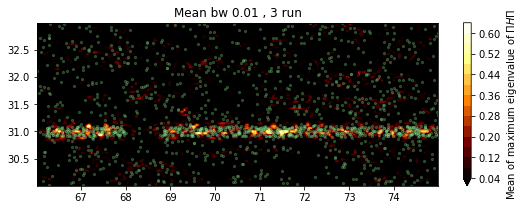

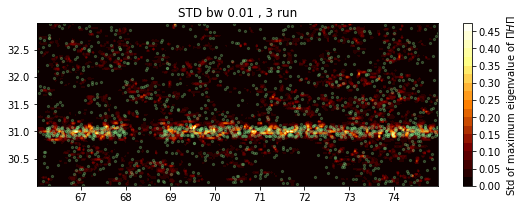

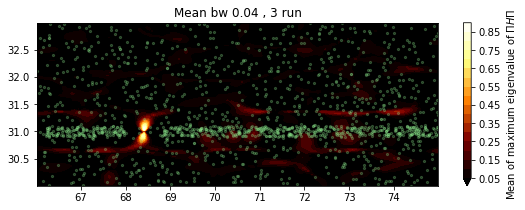

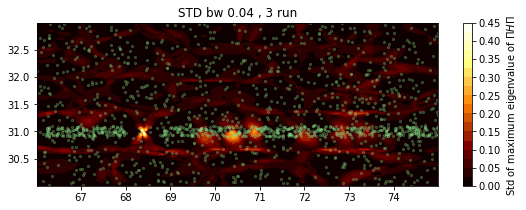

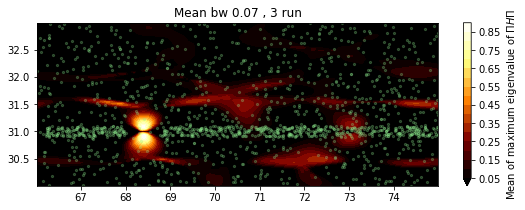

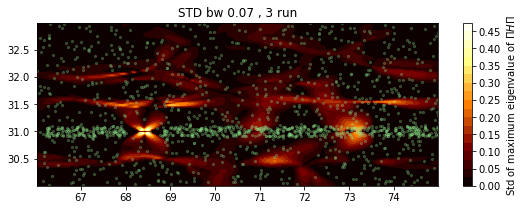

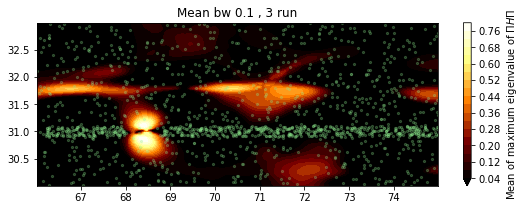

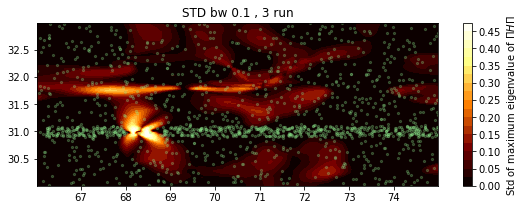

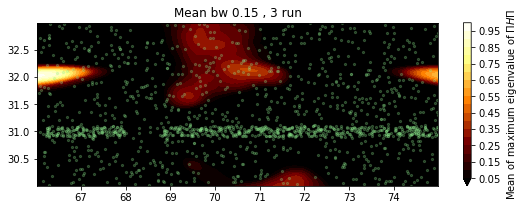

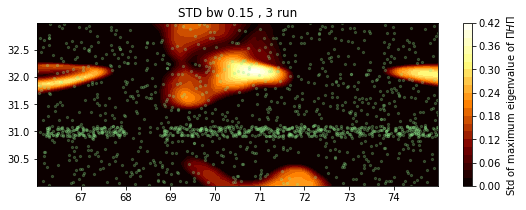

In [52]:
## Average over boot and... over bw?

## Average over boot first and check mean / std for each bw:

for bw in list_of_bws_resc:
    
    all_maxeigval = np.zeros((nb_of_boot, gridding_size[0], gridding_size[1]))
    for i in range(nb_of_boot):
        key = str(i)+"_"+ str(bw)
        all_maxeigval[i] = MinMaxScaler().fit_transform(dic_maxeigval_PiHPi_resh_rescl[key].reshape(-1,1)).reshape((gridding_size[0],
                                                                                                            gridding_size[1]))
    avg_maxeigval = np.mean(all_maxeigval, axis=0)
    std_maxeigval = np.std(all_maxeigval, axis=0)
    

    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], avg_maxeigval, 20, cmap=cm.afmhot, extend='min')
    plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)
    #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Mean of maximum eigenvalue of $\Pi H \Pi$")
    plt.title(f"Mean bw {bw} , {nb_of_boot} run")
    plt.show()
    
    plt.figure(figsize=(xsize, ysize))
    pi = plt.contourf(meshgrid[0], meshgrid[1], std_maxeigval, 20, cmap=cm.afmhot)#, extend='min')
    plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)
    #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
    cb = plt.colorbar(pi, label=f"Std of maximum eigenvalue of $\Pi H \Pi$ ")
    plt.title(f"STD bw {bw} , {nb_of_boot} run")
    plt.show()
    
    
    print("=="*5)

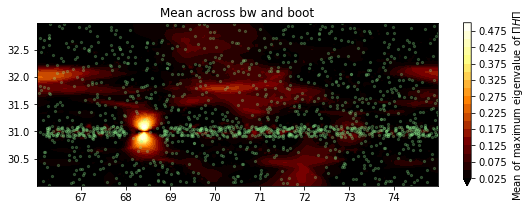

In [53]:
## Average over boot and... over bw?

## Average over boot first and check mean / std for each bw:
cnt_ = 0

all_maxeigval = np.zeros((nb_of_boot*len(list_of_bws), gridding_size[0], gridding_size[1]))
for bw in list_of_bws_resc:
    
    for i in range(nb_of_boot):
        key = str(i)+"_"+ str(bw)
        all_maxeigval[cnt_] = MinMaxScaler().fit_transform(
                                dic_maxeigval_PiHPi_resh_rescl[key].reshape(-1,1)).reshape((gridding_size[0],
                                                                                    gridding_size[1]))
        cnt_+=1
        
avg_maxeigval = np.mean(all_maxeigval, axis=0)
std_maxeigval = np.std(all_maxeigval, axis=0)

 


plt.figure(figsize=(xsize, ysize))
pi = plt.contourf(meshgrid[0], meshgrid[1], avg_maxeigval, 20, cmap=cm.afmhot, extend='min')
#plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
#plt.scatter(data[:,0], data[:,1], s=5)
plt.scatter(data[:,0], data[:,1], s=5, c='lightgreen', alpha=.25)

cb = plt.colorbar(pi, label=f"Mean of maximum eigenvalue of $\Pi H \Pi$ ")
plt.title(f"Mean across bw and boot")
plt.show()



# plt.figure(figsize=(xsize, ysize))
# pi = plt.contourf(meshgrid[0], meshgrid[1], std_maxeigval, 20, cmap=cm.afmhot)#, extend='min')
# #plt.contour(meshgrid[0], meshgrid[1], density_matr, 20, cmap=cm.spring, alpha=.5)
# plt.scatter(data[:,0], data[:,1], s=5)
# cb = plt.colorbar(pi, label=f"Std of maximum eigenvalue of $\Pi H \Pi$ ")
# plt.title(f"Std  bw {bw} , {nb_of_boot} run")
# plt.show()